In [1]:
import os
import mlflow

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [2]:
import pandas as pd
df = pd.read_pickle('../data/CleanCarData.pkl')
display(df.head(10))


,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.349609,5.589844,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.750000,9.539062,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.250000,9.851562,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.849609,4.148438,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.601562,6.871094,42450,Diesel,Dealer,Manual,0
5,vitara brezza,2018,9.250000,9.828125,2071,Diesel,Dealer,Manual,0
6,ciaz,2015,6.750000,8.117188,18796,Petrol,Dealer,Manual,0
7,s cross,2015,6.500000,8.609375,33429,Diesel,Dealer,Manual,0
8,ciaz,2016,8.750000,8.890625,20273,Diesel,Dealer,Manual,0
9,ciaz,2015,7.449219,8.921875,42367,Diesel,Dealer,Manual,0


In [3]:
df = df.rename(columns={'Present_Price': 'target'})

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=2)

In [5]:
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
cat_features

['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission']

In [6]:
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features

['Year', 'Selling_Price', 'Driven_kms', 'Owner']

In [7]:
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999999) # unknown_value нужно выбирать с умом
regressor = RandomForestRegressor()

In [8]:
# Для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [9]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Selling_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission'])])),
                ('model', RandomForestRegressor())])

In [10]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 1.254570376747533,
 'mape': 0.873354193228003,
 'mse': 2.8217498434044814}

In [11]:
# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   

In [18]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "car_project_lab3"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "car_model_rf"

## Логирование (9)

In [19]:
# Обязательно логируем сигнатуру модели и пример входных данных. Подготовим их
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)
req_file = '../requirements.txt'
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
#params_dict = {'n_estimators': 10, 'max_depth': 10}
params_dict = pipeline.get_params()

/home/dexter/study/IsLab/.my_venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [20]:
experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
#xperiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

In [21]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
        # получаем уникальный идентификатор запуска эксперимента
        run_id = run.info.run_id 
        mlflow.sklearn.log_model(pipeline, 
                                    artifact_path="models",
                                    signature=signature,
                                    input_example=input_example,
                                    pip_requirements=req_file
                                )
        mlflow.log_metrics(metrics)
        mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/19 13:59:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline model at: http://127.0.0.1:5000/#/experiments/2/runs/e2b90cdb854e465d91997148577ba19a.
2024/11/19 13:59:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2.


In [ ]:
#experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
#mlflow.delete_experiment(experiment_id)

In [107]:
#mlflow.search_runs(
    #experiment_ids=[experiment_id],
    #experiment_names=[EXPERIMENT_NAME],
    #filter_string='status = "DELETED"'
    #filter_string='metrics.mae > 1'
    
#)

## Модель №2

In [22]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression

In [23]:
X_train_sklearn = X_train.copy()

In [24]:
# Выбираем 2-3 числовых признака для создания полиномиальных признаков
numeric_features = ["Year", "Driven_kms"]  # Замените на имена числовых признаков

In [25]:
# Определяем трансформации
transformers=[
    ('num', s_scaler, num_features),  # преобразования для числовых признаков
    ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
]

In [26]:
# Полиномиальные признаки
if numeric_features:
    transformers.append(
        ("poly", Pipeline([
            ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler", StandardScaler())  # Шкалируем полиномиальные признаки
        ]), numeric_features)
    )

In [27]:
# Разбиваем на корзины с использованием KBinsDiscretizer, если временных признаков нет
transformers.append(
    ("kbin", KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform"), numeric_features)
)

In [28]:
# ColumnTransformer для применения трансформаций
preprocessor = ColumnTransformer(transformers=transformers, remainder="passthrough")

# Применяем трансформации к X_train_sklearn
X_train_fe_sklearn = preprocessor.fit_transform(X_train_sklearn)

# Сохраняем имена столбцов
column_names = preprocessor.get_feature_names_out()
pd.DataFrame(column_names).to_csv("column_names.csv", index=False)  # Сохраняем в файл



X_transformed_df = pd.DataFrame(X_train_fe_sklearn, columns=preprocessor.get_feature_names_out())


# Шаг 3: Создаем Pipeline для модели
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('model', regressor)  # Замените на вашу модель
])




In [29]:
# Обучаем модель
model_sklearn = pipeline.fit(X_train, y_train)

In [30]:
model_sklearn

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Year', 'Selling_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly_features',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Year', 'Driven_kms']),
                                                 ('kbin',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='uniform'),
                                                  ['Year', 'Driven_kms'])])),
                ('model', RandomForestRegressor())])

In [31]:
predictions = model_sklearn.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 1.1642715935958061,
 'mape': 0.747733735865558,
 'mse': 2.4521235451248913}

In [32]:
RUN_NAME = 'fe_sklearn'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(model_sklearn, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact("column_names.csv", artifact_path="columns")
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/19 14:00:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run fe_sklearn at: http://127.0.0.1:5000/#/experiments/2/runs/57318646e18a4fe8adff69319b2cf378.
2024/11/19 14:00:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2.


In [33]:
display(X_train.head(10))

,Car_Name,Year,Selling_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
155,Honda Activa 4G,2017,0.479980,4300,Petrol,Individual,Automatic,0
104,Royal Enfield Classic 350,2017,1.349609,4100,Petrol,Individual,Manual,0
285,jazz,2016,7.398438,15059,Petrol,Dealer,Automatic,0
219,verna,2012,4.500000,36000,Petrol,Dealer,Manual,0
291,brio,2015,5.398438,31427,Petrol,Dealer,Manual,0
84,innova,2005,3.490234,197176,Diesel,Dealer,Manual,0
24,wagon r,2013,2.900391,56879,Petrol,Dealer,Manual,0
280,brio,2015,5.250000,14465,Petrol,Dealer,Manual,0
113,Mahindra Mojo XT300,2016,1.150391,35000,Petrol,Individual,Manual,0
153,Bajaj Pulsar NS 200,2013,0.500000,45000,Petrol,Individual,Manual,0


In [34]:
display(X_transformed_df.head(10))

,num__Year,num__Selling_Price,num__Driven_kms,num__Owner,cat__Car_Name,cat__Fuel_Type,cat__Selling_type,cat__Transmission,poly__Year,poly__Driven_kms,poly__Year^2,poly__Year Driven_kms,poly__Driven_kms^2,kbin__Year,kbin__Driven_kms
0,1.171606,-0.819553,-0.797744,-0.180741,22.0,2.0,1.0,0.0,1.171606,-0.797744,1.172873,-0.799057,-0.186065,2.0,0.0
1,1.171606,-0.657343,-0.802502,-0.180741,34.0,2.0,1.0,1.0,1.171606,-0.802502,1.172873,-0.803836,-0.186163,2.0,0.0
2,0.828808,0.470933,-0.541795,-0.180741,69.0,2.0,0.0,0.0,0.828808,-0.541795,0.829287,-0.542137,-0.173878,2.0,0.0
3,-0.542382,-0.069707,-0.043623,-0.180741,75.0,2.0,0.0,1.0,-0.542382,-0.043623,-0.543355,-0.043681,-0.111314,1.0,0.0
4,0.486011,0.097877,-0.152412,-0.180741,49.0,2.0,0.0,1.0,0.486011,-0.152412,0.485871,-0.151570,-0.129356,2.0,0.0
5,-2.941964,-0.258056,3.790644,-0.180741,68.0,1.0,0.0,1.0,-2.941964,3.790644,-2.938919,3.781911,2.087737,0.0,1.0
6,-0.199584,-0.368079,0.453074,-0.180741,77.0,2.0,0.0,1.0,-0.199584,0.453074,-0.200450,0.454685,0.002155,2.0,0.0
7,0.486011,0.070189,-0.555926,-0.180741,49.0,2.0,0.0,1.0,0.486011,-0.555926,0.485871,-0.556495,-0.174904,2.0,0.0
8,0.828808,-0.694503,-0.067412,-0.180741,32.0,2.0,1.0,1.0,0.828808,-0.067412,0.829287,-0.065859,-0.115469,2.0,0.0
9,-0.199584,-0.815819,0.170481,-0.180741,11.0,2.0,1.0,1.0,-0.199584,0.170481,-0.200450,0.171385,-0.068658,2.0,0.0


## 12

In [35]:
from mlxtend.feature_selection import SequentialFeatureSelector 
#from sklearn.feature_selection import SequentialFeatureSelector

In [36]:
sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=3), 
                                k_features=4,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_transformed_df,y_train)

SequentialFeatureSelector(cv=2, estimator=RandomForestRegressor(n_estimators=3),
                          k_features=(4, 4), scoring='neg_mean_absolute_error')

In [37]:
selected_features_sfs = X_transformed_df.loc[:, sfs.k_feature_names_]
selected_features_sfs

,num__Selling_Price,cat__Car_Name,poly__Year,poly__Year^2
0,-0.819553,22.0,1.171606,1.172873
1,-0.657343,34.0,1.171606,1.172873
2,0.470933,69.0,0.828808,0.829287
3,-0.069707,75.0,-0.542382,-0.543355
4,0.097877,49.0,0.486011,0.485871
...,...,...,...,...
220,-0.172443,60.0,0.486011,0.485871
221,-0.088651,74.0,-0.885179,-0.886090
222,0.480405,53.0,-0.199584,-0.200450
223,0.536510,58.0,0.828808,0.829287


In [38]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
with open("rfe_sfs_idx.txt", "w") as output:
    output.write(str(rfe_sfs_idx))
rfe_sfs_idx
rfe_sfs_col = list(sfs.k_feature_names_)
with open("rfe_sfs_col.txt", "w") as output:
    output.write(str(rfe_sfs_col))
rfe_sfs_col

['num__Selling_Price', 'cat__Car_Name', 'poly__Year', 'poly__Year^2']

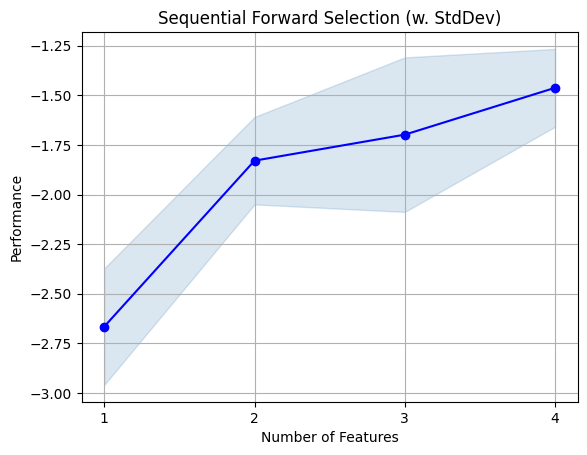

In [39]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [40]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [41]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', regressor)
])

rfe_sfs_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Year', 'Selling_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly_features',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Year', 'Driven_kms']),
                                                 ('kbin',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='uniform'),
                                                  ['Year', 'Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x71423b6c2ba0>),
                ('model', RandomForestRegressor())])

In [42]:
predictions_sfs = rfe_sfs_pipeline.predict(X_test)

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_sfs)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_sfs)
metrics["mse"] = mean_squared_error(y_test, predictions_sfs)

metrics

{'mae': 1.2319684480365956,
 'mape': 0.7747082297206077,
 'mse': 3.162482402588131}

In [43]:
RUN_NAME = 'SFS'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_sfs_col.txt')
    mlflow.log_artifact('rfe_sfs_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/19 14:00:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run SFS at: http://127.0.0.1:5000/#/experiments/2/runs/46dac938586a4514ac7e386fd0aa7471.
2024/11/19 14:00:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2.


In [44]:
import optuna

In [45]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import mlflow

def objective(trial):
    # Гиперпараметры для настройки
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    # Создаем и обучаем модель
    opt_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features))
    ])
    
    opt_pipeline.fit(X_train, y_train)

    # Предсказание и расчет метрики MAE
    preds = opt_pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae  # Минимизируем MAE

# Запускаем оптимизацию
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Выводим лучшие гиперпараметры
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2024-11-19 14:00:54,728] A new study created in memory with name: no-name-7d4953ee-5cba-4f94-bd98-d207c23e9ea5
[I 2024-11-19 14:00:54,967] Trial 0 finished with value: 1.9737164998107424 and parameters: {'n_estimators': 282, 'max_depth': 5, 'max_features': 0.5978212579013719}. Best is trial 0 with value: 1.9737164998107424.
[I 2024-11-19 14:00:55,161] Trial 1 finished with value: 1.3667622260615317 and parameters: {'n_estimators': 158, 'max_depth': 17, 'max_features': 0.800399906157709}. Best is trial 1 with value: 1.3667622260615317.
[I 2024-11-19 14:00:55,302] Trial 2 finished with value: 1.539148768459778 and parameters: {'n_estimators': 135, 'max_depth': 17, 'max_features': 0.510242362696998}. Best is trial 1 with value: 1.3667622260615317.
[I 2024-11-19 14:00:55,433] Trial 3 finished with value: 1.7527248132778177 and parameters: {'n_estimators': 127, 'max_depth': 13, 'max_features': 0.41348879552617535}. Best is trial 1 with value: 1.3667622260615317.
[I 2024-11-19 14:00:55,76

Number of finished trials: 10
Best trial: {'n_estimators': 269, 'max_depth': 18, 'max_features': 0.9904036799047524}


In [46]:
# Используем оптимальные параметры
best_params = study.best_trial.params
opt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**best_params))
])

opt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Year', 'Selling_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly_features',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Year', 'Driven_kms']),
                                                 ('kbin',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='uniform'),
                                                  ['Year', 'Driven_kms'])])),
                ('model',
                 RandomForestRegressor(max_depth=18,
                                       max_features=0.9904036799047524,
                                       n_estimators=269))])

In [47]:
predictions = opt_pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 1.1975551926910097,
 'mape': 0.8121116059147834,
 'mse': 2.4318517929780836}

In [48]:
RUN_NAME = 'optuna_model'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(opt_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')


2024/11/19 14:01:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run optuna_model at: http://127.0.0.1:5000/#/experiments/2/runs/1b0acaa58c1f482287514a31ab372c98.
2024/11/19 14:01:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2.


## 14

In [49]:
# Соединяем обратно обучающую и тестовую выборки для признаков и целевой переменной
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

In [50]:
X_train_sklearn = X_full.copy()

In [51]:
# Выбираем 2-3 числовых признака для создания полиномиальных признаков
numeric_features = ["Year", "Driven_kms"]  # Замените на имена числовых признаков
# Определяем трансформации
transformers=[
    ('num', s_scaler, num_features),  # преобразования для числовых признаков
    ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
]
# Полиномиальные признаки
if numeric_features:
    transformers.append(
        ("poly", Pipeline([
            ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler", StandardScaler())  # Шкалируем полиномиальные признаки
        ]), numeric_features)
    )
# Разбиваем на корзины с использованием KBinsDiscretizer, если временных признаков нет
transformers.append(
    ("kbin", KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform"), numeric_features)
)

In [52]:
# ColumnTransformer для применения трансформаций
preprocessor = ColumnTransformer(transformers=transformers, remainder="passthrough")

# Применяем трансформации к X_train_sklearn
X_train_fe_sklearn = preprocessor.fit_transform(X_train_sklearn)

# Сохраняем имена столбцов
column_names = preprocessor.get_feature_names_out()
pd.DataFrame(column_names).to_csv("column_names_final.csv", index=False)  # Сохраняем в файл



X_transformed_df = pd.DataFrame(X_train_fe_sklearn, columns=preprocessor.get_feature_names_out())


# Шаг 3: Создаем Pipeline для модели
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('model', regressor)  # Замените на вашу модель
])

In [53]:
# Обучаем модель
final_model = pipeline.fit(X_full, y_full)


In [54]:
input_example = X_full.head(5)
RUN_NAME = 'final_model'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
        # получаем уникальный идентификатор запуска эксперимента
        run_id = run.info.run_id 
        mlflow.sklearn.log_model(pipeline, 
                                    artifact_path="models",
                                    signature=signature,
                                    input_example=input_example,
                                    pip_requirements=req_file
                                )
        mlflow.log_params(model_sklearn.get_params())
        mlflow.log_artifact("column_names_final.csv", artifact_path="columns")
        
run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/19 14:01:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run final_model at: http://127.0.0.1:5000/#/experiments/2/runs/4b11c54b2ea144ed871b2184fd15997b.
2024/11/19 14:01:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2.
